# Natural Language Processing: News Analysis
[Peter Damyanov](https://github.com/petardmnv)

###### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
#nltk.download()
#from nltk.book import *

import requests

from datetime import datetime

from bs4 import BeautifulSoup

import re

### Abstract

### Research objective

### Theoretical background and hypothesis development

###  Methodology

### Implementing methodology

###### 1.Web Scraping

Get the most popular business news from [CNN](https://edition.cnn.com/business) for the current day.
Get the most popular business news from [BBC](https://www.bbc.com/news/business) for the current day.

**Warning** Scraping two completely different sites is not easy and most of the code will be different. Ie we will not be able to use the functions we have for both sites, so there will be similar functions in logic.

In [2]:
cnn_link = 'https://edition.cnn.com/business'
bbc_link = 'https://www.bbc.com/news/business'    

In [3]:
#Get page content
def get_page_content(link):
    page = requests.get(link)
    return page

Secondly we are going to scrape this page, so we can access "top news" urls. To scrape the page we need BeautifulSoup object. 

In [4]:
def create_soup(page):
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

There are duplicating links so we are going to create function which will remove duplicated links. The easiest way of doing that is to cast "links" to set, because set items are unordered, unchangeable, and do not allow duplicate values.

In [5]:
def clear_duplicate_links(links):
    return list(set(links))

Start with CNN

Extact links from scraped data and clear duplicating, if there is such links.

In [6]:
def extract_cnn_links(link):
    page = get_page_content(link)
    soup = create_soup(page)
    cnn_extracted_links = [l['href'] for l in soup.find('section').find("ul").find_all('a')]
    cnn_extracted_links = clear_duplicate_links(cnn_extracted_links)
    return cnn_extracted_links

Let's see extracted links from cnn.

In [7]:
cnn_extracted_links = extract_cnn_links(cnn_link)
cnn_extracted_links

['/2021/08/08/tech/metaverse-explainer/index.html',
 '/2021/08/08/media/suicide-squad-box-office/index.html',
 '/2021/08/09/business/vaccine-mandates-retail-customers/index.html',
 '/2021/08/09/tech/radiative-cooling-skycool-electricity-environment/index.html',
 '/2021/08/09/media/mike-richards-jeopardy-host-controversy/index.html',
 '/2021/08/10/media/covid-19-vaccine-rejection-news-coverage-reliable-sources/index.html',
 '/2021/08/10/investing/amc-bitcoin-crypto-payment-intl-hnk/index.html',
 '/2021/08/09/investing/warren-buffett-berkshire-hathaway-earnings/index.html',
 '/2021/08/09/business/money/early-retirement-fire-feseries/index.html',
 '/2021/08/09/politics/cryptocurrency-infrastructure-deal-lummis-toomey/index.html',
 '/2021/08/09/economy/record-job-openings-june/index.html',
 '/2021/08/10/energy/cambo-oilfield-shell-siccar-point/index.html',
 '/2021/08/09/investing/draftkings-golden-nugget-online-gaming/index.html']

As you can see we can get article type from it's link. So let's create function that gets the article type.

In [8]:
def get_cnn_news_type_from_link(link):
    #link contains date of publishing than article type
    #For example /2021/08/06/economy/july-jobs-report/index.html
    # So we can remove first 12 characters and than get article type
    link = link[12:]
    # To determine the end ot article we will append to our variable character after character until we
    # get to '/' 
    news_type = []
    for c in link:
        if c == '/':
            break
        news_type.append(c)
    return "".join(news_type)

Result:

In [9]:
cnn_news_types = []
for l in cnn_extracted_links:
    cnn_news_types.append(get_cnn_news_type_from_link(l))
    
cnn_news_types

['tech',
 'media',
 'business',
 'tech',
 'media',
 'media',
 'investing',
 'investing',
 'business',
 'politics',
 'economy',
 'energy',
 'investing']

We can plot the results using bar chart to see the type of news that occurs most.

In [10]:
news_types_frequency = nltk.FreqDist(cnn_news_types)

In [11]:
def plot_types_of_news(news_types_frequency):
    plt.bar([t for t in news_types_frequency], [news_types_frequency[t] for t in news_types_frequency])

    plt.xlabel("News Type")
    plt.ylabel("Count news")
    plt.show()

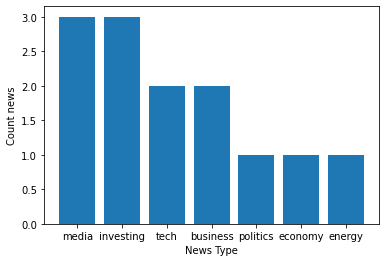

In [12]:
plot_types_of_news(news_types_frequency)

We want just news about business, investing, tech and economy. Create function remove_usless_news().

In [13]:
def remove_usless_news(dataframe):
    #Yes it is ugly but it is working
    dataframe.drop(dataframe[(dataframe['news_type'] != 'business') &  (dataframe['news_type'] != 'tech') & (dataframe['news_type'] != 'investing') & (dataframe['news_type'] != 'economy')].index, axis=0, inplace=True)
    return dataframe.reset_index(drop=True)

Then we want to know the date of current article. Again we can get it from article url.

In [14]:
def get_cnn_news_date_from_link(link):
    raw_date = link[1:11]
    date = raw_date.replace('/', '-')
    return date

Result:

In [15]:
for l in cnn_extracted_links:
    print(get_cnn_news_date_from_link(l))

2021-08-08
2021-08-08
2021-08-09
2021-08-09
2021-08-09
2021-08-10
2021-08-10
2021-08-09
2021-08-09
2021-08-09
2021-08-09
2021-08-10
2021-08-09


CNN ends here.

Start BBC web scraping.

Extact links from scraped data and clear duplicating, if there is such links.

After web scraping page we got unusable links like this - **/news/business-58156118/#comp-comments-button**.


Here is the part of the result:

'/news/business',

 '/news/technology-58146039',
 
 '/news/technology',
 
 '/news/business-58154046',
 
 '/news/business-58156118/#comp-comments-button',
 
 '/news/technology-58145808',
 
 '/news/business-58156118',
 .....
 

So we need to create function 'remove usless links' which removes usless links from our result.

In [89]:
def remove_usless_links(links):
    pat = r'/news/\w+[-]\d+'
    correct_links = []
    for l in links:
        obj = re.findall(pat, l)
        if len(obj) > 0:
            correct_links.append(obj[0])
    return correct_links

Result from this function is:

'/news/technology-58146039',

 '/news/business-58154046',
 
 '/news/business-58156118',
 
 '/news/technology-58145808',
 
 '/news/business-58156118',
 
 '/news/business-58155103',
 
 '/news/business-58095639',
 
 '/news/business-57981598',
 
 '/news/technology-58145943',
 
 '/news/technology-58146039'
 
 
 Clean links :)
 
This is working properly so let's add it to main bbc function

In [91]:
def extract_bbc_links(link):
    page = get_page_content(link)
    soup = create_soup(page)
    bbc_extracted_links = [l['href'] for l in soup.find('div', {'class', "gel-layout gel-layout--equal"}).find_all('a')]
    bbc_extracted_links = clear_duplicate_links(bbc_extracted_links)
    bbc_extracted_links = remove_usless_links(bbc_extracted_links)
    return bbc_extracted_links

In [92]:
extracted_bbc_links = extract_bbc_links(bbc_link)
extracted_bbc_links

['/news/technology-58146039',
 '/news/business-58154046',
 '/news/business-58156118',
 '/news/technology-58145808',
 '/news/business-58156118',
 '/news/business-58155103',
 '/news/business-58095639',
 '/news/business-57981598',
 '/news/technology-58145943',
 '/news/technology-58146039']

In [93]:
for l in extracted_bbc_links:
    print('https://www.bbc.com' + l)

https://www.bbc.com/news/technology-58146039
https://www.bbc.com/news/business-58154046
https://www.bbc.com/news/business-58156118
https://www.bbc.com/news/technology-58145808
https://www.bbc.com/news/business-58156118
https://www.bbc.com/news/business-58155103
https://www.bbc.com/news/business-58095639
https://www.bbc.com/news/business-57981598
https://www.bbc.com/news/technology-58145943
https://www.bbc.com/news/technology-58146039


Remove usless links using regex. Usless link - news/business-58156118/**#comp-comments-button**

['/news/technology-58146039',
 '/news/business-58154046',
 '/news/business-58156118',
 '/news/technology-58145808',
 '/news/business-58156118',
 '/news/business-58155103',
 '/news/business-58095639',
 '/news/business-57981598',
 '/news/technology-58145943',
 '/news/technology-58146039']

For more clarity we want to get our data to DataFrame. For now we want to have columns for article headline, context, date and type.

For that we need to get content and headline from every article. We already have article type and date.

But firstly we have saved data from previous days. So let's get DataFrame and than add new data.

DF is stored in **data** folder into csv file.

In [16]:
def get_dataframe_from_csv(path):
    df = pd.read_csv(path)
    return df

One big problem occurs when we run this notebook several times in one day. We will add the same rows. So let's make function that removes diplicating rows.

In [17]:
def remove_duplicating_rows(dataframe):
    duplicated = dataframe[dataframe.duplicated()]
    dataframe.drop(duplicated.index, axis=0, inplace=True)
    return dataframe.reset_index(drop=True)

In [18]:
def search_cnn_links(dataframe, domain, links):
    for l in links:
        date = get_cnn_news_date_from_link(l)
    
        news_type = get_cnn_news_type_from_link(l)
        
        source_link = domain + l
        page = get_page_content(source_link)
        soup = create_soup(page)
        headline = soup.find('h1').text
        
        content = "".join([l.text for l in soup.findAll('div', {"class": "zn-body__paragraph"})])
        
        dataframe.loc[len(dataframe)] = [headline, content, date, news_type]
    dataframe = remove_duplicating_rows(dataframe)

###### 2.Text Analisys

In [19]:
domain = 'https://edition.cnn.com'
filename = 'news'
path = 'data/'+filename
text_data = get_dataframe_from_csv(path)
search_cnn_links(text_data, domain, cnn_extracted_links)
text_data['date'] = pd.to_datetime(text_data['date'])

Save changed DF to .csv file

In [20]:
def save_dataframe_to_csv(dataframe, filename):
    path = "data/" + filename
    dataframe.to_csv(path, index=False)

In [21]:
save_dataframe_to_csv(text_data, 'news')

In [22]:
text_data

,headline,content,date,news_type
0,Alex Trebek's likely 'Jeopardy!' successor def...,"At the same time, he is also confirming has be...",2021-08-09,media
1,"Big moves for oil, gold and bonds after blockb...",A version of this story first appeared in CNN ...,2021-08-09,investing
2,Warren Buffett is buying more of his own stock...,Berkshire (BRKB) reported strong second quarte...,2021-08-09,investing
3,'The Suicide Squad' underperformed at the box ...,So does that mean the film starring Idris Elba...,2021-08-08,media
4,AMC says it'll soon let you pay for your movie...,"In an earnings call Monday, the theater chain ...",2021-08-10,investing
5,Why big chains aren't requiring vaccines for c...,Representatives for retailers and restaurants ...,2021-08-09,business
6,This is a first: The US has 10 million job ope...,That mismatch between worker demand and supply...,2021-08-09,economy
7,This company uses technology and nature to cut...,SkyCool Systems is trying to break that viciou...,2021-08-09,tech
8,You might be able to retire earlier than you t...,Financial Independence Retire Early -- or FIRE...,2021-08-09,business
9,DraftKings buys Golden Nugget Online Gaming fo...,Shares of Golden Nugget Online Gaming skyrocke...,2021-08-09,investing


In [23]:
text_data = remove_usless_news(text_data)
text_data

,headline,content,date,news_type
0,"Big moves for oil, gold and bonds after blockb...",A version of this story first appeared in CNN ...,2021-08-09,investing
1,Warren Buffett is buying more of his own stock...,Berkshire (BRKB) reported strong second quarte...,2021-08-09,investing
2,AMC says it'll soon let you pay for your movie...,"In an earnings call Monday, the theater chain ...",2021-08-10,investing
3,Why big chains aren't requiring vaccines for c...,Representatives for retailers and restaurants ...,2021-08-09,business
4,This is a first: The US has 10 million job ope...,That mismatch between worker demand and supply...,2021-08-09,economy
5,This company uses technology and nature to cut...,SkyCool Systems is trying to break that viciou...,2021-08-09,tech
6,You might be able to retire earlier than you t...,Financial Independence Retire Early -- or FIRE...,2021-08-09,business
7,DraftKings buys Golden Nugget Online Gaming fo...,Shares of Golden Nugget Online Gaming skyrocke...,2021-08-09,investing
8,Domino's is giving away $50 million of free fo...,"The pizza chain announced Monday a ""Surprise F...",2021-08-09,business
9,Why Silicon Valley is betting on making this d...,The metaverse was originally conceived as the ...,2021-08-08,tech


Types of DataFrame are:

In [24]:
text_data.dtypes

headline             object
content              object
date         datetime64[ns]
news_type            object
dtype: object

Content from first article:

In [25]:
text = text_data.loc[0]['content']
print(text_data.loc[0]['headline'])
text

Big moves for oil, gold and bonds after blockbuster US jobs report


'A version of this story first appeared in CNN Business\' Before the Bell newsletter. Not a subscriber? You can sign up right here.How good? Yields on benchmark US 10-year bonds moved higher to roughly 1.3% after the jobs report on Friday, their highest level since July 23.Yields have since fallen back a bit. But the addition of 943,000 jobs in the United States is great news for the economy, making it more likely that the Federal Reserve begins to pull back its stimulus earlier than expected. Continued momentum toward an eventual rate hike could drive yields even higher over the coming months."Friday\'s [jobs] data put Fed tapering back in the middle of the dinner table, sending US yields and the US Dollar higher," said Jeffrey Halley, senior market analyst for Asia Pacific at OANDA.Another move: Gold prices crashed as much as 3.5% on Monday to $1,692.60 per ounce, before making a partial comeback. Silver also dropped.Some of the strength of that reaction was likely due to thin tradin

It our text there are stopwords - high-frequency words like the, to and also that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts.

So we  will remove them from article text.

Firstly let's see what english stopwords are. From NLTK library has a built-in module with stopwords.

In [26]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Tokenize our text into words. 

In [27]:
for i in range(len(text)):
    if text[i] == '.':
        if text[i+1] != ' ':
            text = text[:i+1] + ' ' + text[i+1:]
            
text

tokens = word_tokenize(text)
tokens

['A',
 'version',
 'of',
 'this',
 'story',
 'first',
 'appeared',
 'in',
 'CNN',
 'Business',
 "'",
 'Before',
 'the',
 'Bell',
 'newsletter',
 '.',
 'Not',
 'a',
 'subscriber',
 '?',
 'You',
 'can',
 'sign',
 'up',
 'right',
 'here',
 '.',
 'How',
 'good',
 '?',
 'Yields',
 'on',
 'benchmark',
 'US',
 '10-year',
 'bonds',
 'moved',
 'higher',
 'to',
 'roughly',
 '1',
 '.',
 '3',
 '%',
 'after',
 'the',
 'jobs',
 'report',
 'on',
 'Friday',
 ',',
 'their',
 'highest',
 'level',
 'since',
 'July',
 '23',
 '.',
 'Yields',
 'have',
 'since',
 'fallen',
 'back',
 'a',
 'bit',
 '.',
 'But',
 'the',
 'addition',
 'of',
 '943,000',
 'jobs',
 'in',
 'the',
 'United',
 'States',
 'is',
 'great',
 'news',
 'for',
 'the',
 'economy',
 ',',
 'making',
 'it',
 'more',
 'likely',
 'that',
 'the',
 'Federal',
 'Reserve',
 'begins',
 'to',
 'pull',
 'back',
 'its',
 'stimulus',
 'earlier',
 'than',
 'expected',
 '.',
 'Continued',
 'momentum',
 'toward',
 'an',
 'eventual',
 'rate',
 'hike',
 'could'

Remove stopwords.

In [28]:
words_from_text =[]
for w in tokens:
    if w.lower() not in stopwords.words('english') and w.lower().isalpha():
        words_from_text.append(w)
words_from_text

['version',
 'story',
 'first',
 'appeared',
 'CNN',
 'Business',
 'Bell',
 'newsletter',
 'subscriber',
 'sign',
 'right',
 'good',
 'Yields',
 'benchmark',
 'US',
 'bonds',
 'moved',
 'higher',
 'roughly',
 'jobs',
 'report',
 'Friday',
 'highest',
 'level',
 'since',
 'July',
 'Yields',
 'since',
 'fallen',
 'back',
 'bit',
 'addition',
 'jobs',
 'United',
 'States',
 'great',
 'news',
 'economy',
 'making',
 'likely',
 'Federal',
 'Reserve',
 'begins',
 'pull',
 'back',
 'stimulus',
 'earlier',
 'expected',
 'Continued',
 'momentum',
 'toward',
 'eventual',
 'rate',
 'hike',
 'could',
 'drive',
 'yields',
 'even',
 'higher',
 'coming',
 'months',
 'Friday',
 'jobs',
 'data',
 'put',
 'Fed',
 'tapering',
 'back',
 'middle',
 'dinner',
 'table',
 'sending',
 'US',
 'yields',
 'US',
 'Dollar',
 'higher',
 'said',
 'Jeffrey',
 'Halley',
 'senior',
 'market',
 'analyst',
 'Asia',
 'Pacific',
 'OANDA',
 'Another',
 'move',
 'Gold',
 'prices',
 'crashed',
 'much',
 'Monday',
 'per',
 'oun

In [30]:
freq_words = nltk.FreqDist(words_from_text)

In [31]:
freq_words

FreqDist({'Delta': 7, 'metaverse': 7, 'said': 6, 'higher': 5, 'variant': 5, 'US': 4, 'jobs': 4, 'back': 4, 'could': 4, 'much': 4, ...})

In [32]:
sentences = sent_tokenize(text)
sentences

["A version of this story first appeared in CNN Business' Before the Bell newsletter.",
 'Not a subscriber?',
 'You can sign up right here.',
 'How good?',
 'Yields on benchmark US 10-year bonds moved higher to roughly 1.',
 '3% after the jobs report on Friday, their highest level since July 23.',
 'Yields have since fallen back a bit.',
 'But the addition of 943,000 jobs in the United States is great news for the economy, making it more likely that the Federal Reserve begins to pull back its stimulus earlier than expected.',
 'Continued momentum toward an eventual rate hike could drive yields even higher over the coming months.',
 '"Friday\'s [jobs] data put Fed tapering back in the middle of the dinner table, sending US yields and the US Dollar higher," said Jeffrey Halley, senior market analyst for Asia Pacific at OANDA.',
 'Another move: Gold prices crashed as much as 3.',
 '5% on Monday to $1,692.',
 '60 per ounce, before making a partial comeback.',
 'Silver also dropped.',
 'Som

###  Results

### Limitations and Future Work  (Optional)

### Conclusion

### References

https://arxiv.org/pdf/2107.14681.pdf


https://ocw.mit.edu/courses/biological-engineering/20-109-laboratory-fundamentals-in-biological-engineering-fall-2007/assignments/sci_writing_guid.pdf

https://tjzhifei.github.io/resources/NLTK.pdf

In [ ]:
# fdist1 = FreqDist(text1)

# commons = fdist1.most_common(200)
# commons = commons[-20:] 
# plt.figure(figsize=(20, 10))
# plt.bar([word[0] for word in commons], [word[1] for word in commons])

# plt.show()